# Calculating properties of galaxy halos

In this notebook, I will demonstrate the method used to calculate galaxy properties, such as stellar mass, half-mass radius, and velocity dispersion. These are the properties that we will use to compare with observational data. We will use several functions that were defined in the Halo Manipulation notebook, which we've copied to the `analysis` module in the repository. Additionally, we will also demonstrate how to produce the physical properties, to compare to the observable properties.

In [1]:
import matplotlib
matplotlib.use("TKAgg")
%matplotlib inline

import pynbody
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from analysis import load_snapshot_and_halos
import analysis.conf as conf
import analysis.const as const

pynbody.logger.setLevel(pynbody.logging.ERROR)

/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
s, h = load_snapshot_and_halos(conf.SAMPLE)
halo = h[3]

/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaM0'=3.09e-01
  name, value), RuntimeWarning)
/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaL0'=6.91e-01
  name, value), RuntimeWarning)


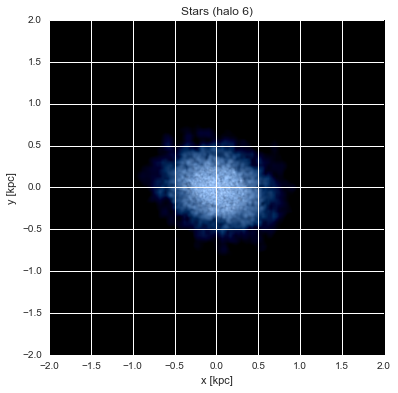

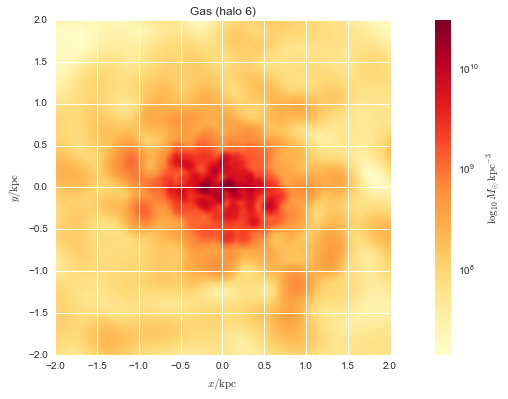

In [3]:
pyplot.rcParams['figure.figsize'] = 16, 6
with pynbody.analysis.halo.center(halo, mode="pot"), pynbody.analysis.angmom.faceon(halo):
    pynbody.plot.stars.render(halo, width="4 kpc")
    pyplot.title("Stars (halo 6)")
    pyplot.figure()
    pynbody.plot.image(halo.g, width="4 kpc", cmap="YlOrRd")
    pyplot.title("Gas (halo 6)")


In [4]:
results = {}

## Observable Properties

The following quantities are calculations from the simulated halos corresponding to observables.

### $R_{halfmass}$

Calculate half-mass radius (radius enclosing half the total mass in a 2D profile face-on profile) by using the function we defined in the Halo Manipulation notebook, which generates a mass profile.

In [5]:
from analysis.transform import get_halfmass_radius

results["R_halfmass"] = get_halfmass_radius(halo)
results["R_halfmass"]

SimArray(0.23809306825355384, 'kpc')

### $M_{star}$

Calculate the stellar mass of the halo by summing up all the star particles.

TODO: do this measurement within some apeture i.e. 12 kpc. it wont actually change the value much, but should be done for the sake of being more realistic to an observable property.

In [6]:
results["M_star"] = pynbody.halo.SimArray(sum(halo.s["mass"]), units=halo.s["mass"].units)
results["M_star"]

SimArray(12402622432.895504, 'Msol')

### $v_{disp}$

Calculating the velocity dispersion is not as straightforward. The velocity dispersion we want is a statistical measurement of the variance of particle velocities along the line of sight. Observers can measure the line-of-sight velocity dispersion by analyzing the width of spectral features, for example.

We can rotate our halo to maximize the velocity dispersion by rotating it side-on relative to the angular momentum vector (our line of sight will be in the same plane as the rotational velocities of particles). Alternatively, we can rotate our halo so as to minimize our velocity dispersion, by going face-on along the angular momentum vector (rotational velcoity will always be perpendicular to our line of sight.

Because of that, we will choose some _typical_ velocity dispersion, and account for the uncertainty. Although we can determine the expected value of the line-of-sight velocity dispersion both analytically and through Monte-Carlo trials at random orientations, for the sake of time and simplicity we will just take a geometric average of the measurement parallel to the plane of the galaxy and the measurement perpendicular to the plane of the galaxy.

$v_{disp} = \sqrt{\frac{\sigma_{x}^2 + \sigma_{y}^2 + \sigma_{z}^2}{3}}$

In [7]:
def get_velocity_dispersion(halo):
    """Calculate velocity dispersion of halo

    Returns geometric mean of the std dev of velocity components perpendicular to ang mom vector
    """
    with pynbody.analysis.halo.center(halo, mode="pot"), pynbody.analysis.angmom.faceon(halo):
        x_velocities = halo.s["vel"][:, 0]
        y_velocities = halo.s["vel"][:, 1]
        z_velocities = halo.s["vel"][:, 2]
        return np.sqrt((pow(np.std(x_velocities), 2) + pow(np.std(y_velocities), 2) + pow(np.std(z_velocities), 2)) / 3.0)

results["v_disp"] = pynbody.halo.SimArray(get_velocity_dispersion(halo), units=halo.s["vel"].units)
results["v_disp"]

SimArray(119.52549068337368, 'km s**-1')

### $M_{dyn}$

A measurement of the dynamical mass of a galaxy can be obtained by applying the virial theorem and using the effective radius $r_e$ and velocity dispersion within that effective radius $\sigma_e$:

$M_{\mathrm{dyn}} = K \frac{\sigma_e^2 r_{e}}{G}$

This equation applies to a virialized system if these two observables can be related to the mean radius of the system and the mean square-velocity of the system through the appropriate choice of parameter $K$.

$\left\langle v^2 \right\rangle \left\langle r \right\rangle = K \sigma_e^2 r_e$

The factor $K$ is dependent on the choice of the observables $r_{e}$ and $\sigma_e$. By choosing $r_e$ to be the half-light radius and $\sigma_e$ to be the line-of-sight velocity dispersion, \citet{Cappellari2006} calibrated the the value of $K$ to be $5.0 \pm 0.1$, a value which has since been used in dynamical mass estimations. In this paper, we use the definition of dynamical mass:

$M_{\mathrm{dyn}} = (5.0 \pm 0.1) \frac{\sigma_e^2 r_e}{G}$

As a measurement of the total mass of a galaxy, the observable $M_{\mathrm{dyn}}$ represents the sum of all components of the galaxy: stars, dark matter, and gas.

Here we will set $K=5$, our above calculated values for velocity dispersion as $\sigma_e$, and half-mass radius as $r_e$. There is also an emperically observed relationship between half-mass and half-light radius which we can use to be more in line with observations, which use half-light radius.

In [8]:
results["M_dyn"] = (const.K * results["v_disp"]**2 * results["R_halfmass"] / const.G).in_units("Msol")
results["M_dyn"]

SimArray(3954367172.9653554, 'Msol')

## Physical Properties

We will want to compare the measurements inferred from observable properties to the actual physical quantities of the simulated halo (this is obviously something we cannot do for observations of a real galaxy!)

We want the physical properties consistent the virial theorem. We will use a sphere with radius equal to the half-mass radius, that theoretically should allow us to compare to the observable properties we calculated in the previous section.

In [9]:
cen = pynbody.analysis.halo.center(halo, retcen=True)

sphere = halo[pynbody.filt.Sphere(results["R_halfmass"], cen=cen)]

results["M_total"] = pynbody.halo.SimArray(sum(sphere["mass"]), units=sphere["mass"].units)
results["M_s"] = pynbody.halo.SimArray(sum(sphere.s["mass"]), units=sphere["mass"].units)
results["M_g"] = pynbody.halo.SimArray(sum(sphere.g["mass"]), units=sphere["mass"].units)
results["M_d"] = pynbody.halo.SimArray(sum(sphere.d["mass"]), units=sphere["mass"].units)

results["M_total"], results["M_s"], results["M_g"], results["M_d"]

(SimArray(4001362106.8911057, 'Msol'),
 SimArray(3453368909.5855346, 'Msol'),
 SimArray(247523086.4557488, 'Msol'),
 SimArray(300470110.8498195, 'Msol'))